# MarketPlace Reviews classification

In [3]:
import numpy as np
import pandas as pd
import string
import time

# Machine learning
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
from funcsigs import signature
import seaborn as sns
from seaborn import axes_style
from seaborn import countplot

# NLP
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# 1) Data exploration

## 1.1) Data loading

In [4]:
data = pd.read_csv('train.csv', sep=";")
print("data shape: ", data.shape)
data.head()

data shape:  (60000, 6)


,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,77d2dbd504b933ab3aaf7cb0cd81c22f7c3549012f4f88...,1
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1


In [5]:
# remove ID column
data = data.iloc[:, 1:]

## 1.2) Target

We check if the labels are well balanced.

In [6]:
data['Target'].value_counts()

1    33291
0    26709
Name: Target, dtype: int64

We see that there is about as many instances labeled as useful (1) as not useful (0).

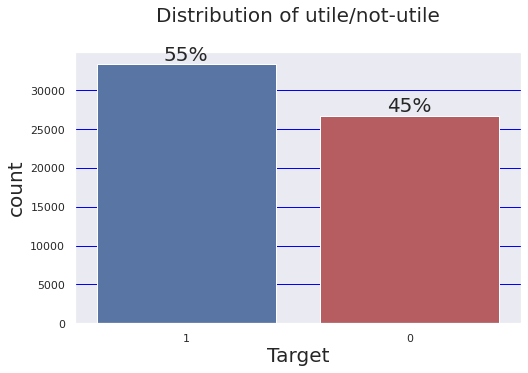

In [7]:
rc={'axes.labelsize': 20, 'font.size': 20, 'legend.fontsize': 20, 'axes.titlesize': 20}
sns.set(rc=rc)

order = data['Target'].value_counts(ascending=False).index
with axes_style({'grid.color': "blue"}):
    fig = plt.figure(figsize=(8,5))
    ax = countplot(data=data,x=data['Target'],
                   order=order,
                   palette=["C0","r"])
    plt.title('Distribution of utile/not-utile', pad=30)
    e = data['Target'].value_counts()[0]
    p = data['Target'].value_counts()[1]
    tot = e+p
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}%'.format(100.*y/tot), (x.mean(),y),ha='center', va='bottom')       
plt.show()

## 1.3) Hash code

The Hash code identifies different products.
We see that we have several identical hashes, which therefore identify the same product.

In [8]:
data['product'].nunique()

46293

In [9]:
data_gr_prod = data.groupby('product')
y = []
for key, group in data_gr_prod:
    y.append(len(group))

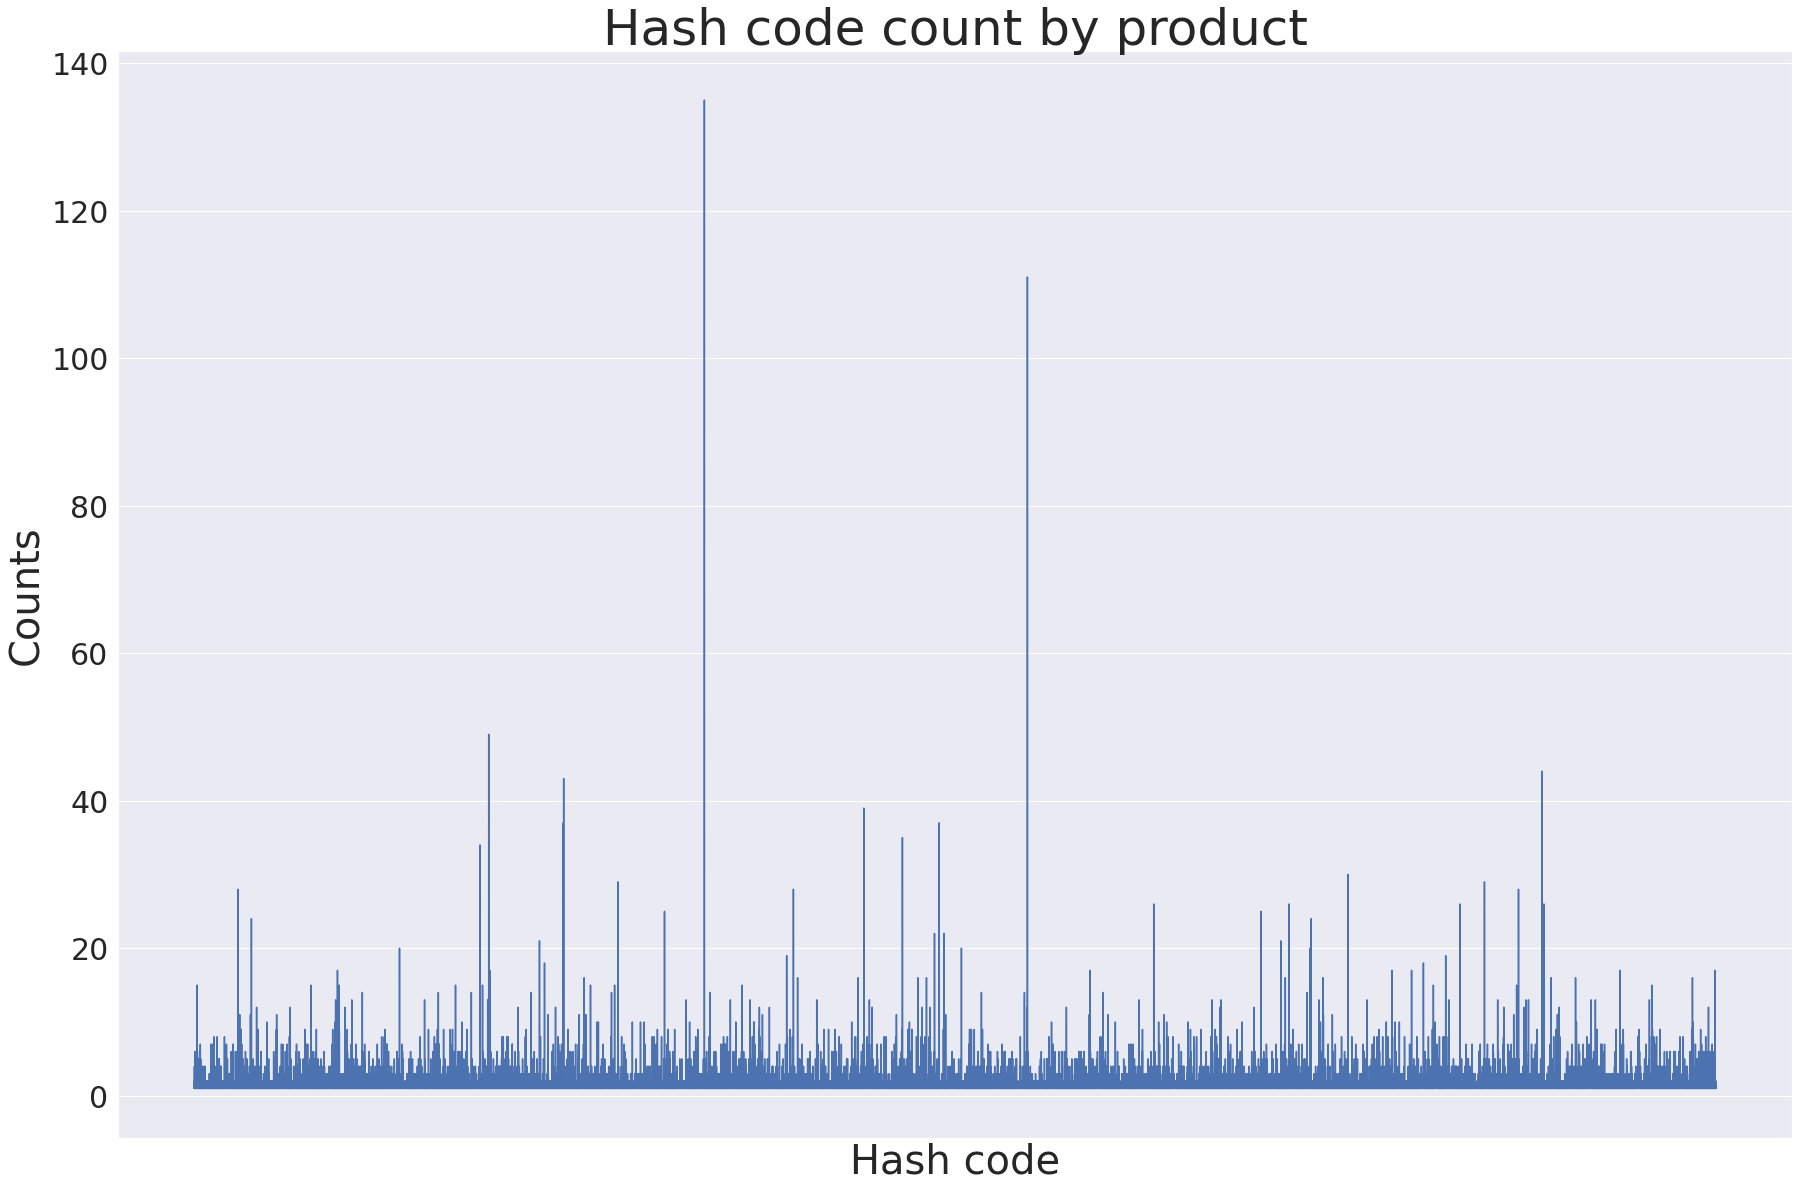

In [10]:
plt.figure(figsize=(30,20))
plt.plot(np.arange(0,len(y)), y)
plt.yticks(fontsize=30)
plt.xticks([])
plt.xlabel("Hash code", fontsize=40)
plt.ylabel("Counts", fontsize=40)
plt.title("Hash code count by product", fontsize=50)
plt.show()

There are many different products, including 2 products in larger quantities (almost 140 and about 130). So we keep this variable and we must encode it.


### Hash code encoding

In [11]:
#encoder = ce.backward_difference.BackwardDifferenceEncoder()
encoder = LabelEncoder()

#data_tot = pd.concat([data['product'], data_test['product']])
data_tot = encoder.fit_transform(data['product'])
sec = data.shape[0]
data['product'] = data_tot[:sec]
#data_test['product'] = data_tot[sec:]

"""
#encoder = OneHotEncoder() 
data = pd.get_dummies(data, 
                      columns=["product"], 
                      sparse=True)
data.shape # (60000, 46297)
"""

'\n#encoder = OneHotEncoder() \ndata = pd.get_dummies(data, \n                      columns=["product"], \n                      sparse=True)\ndata.shape # (60000, 46297)\n'

## 1.4) Review stars

In [12]:
data['review_stars'].value_counts()

5    38405
4    11307
3     4586
1     3895
2     1807
Name: review_stars, dtype: int64

In [13]:
data['review_stars'].isnull().sum()

0

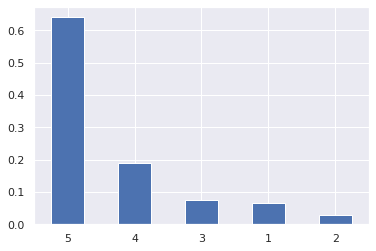

In [14]:
rs = data['review_stars'].value_counts(normalize=True)
rs.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

The graph shows that there are more than 60% of comments at 5 stars, and very few at 2 stars.

Below we perform an ANOVA test to assess the dependence between the Target and the variable 'review_stars'. We obtain a large F-value and a p_value $ p >> 0.05 $, which means that the null hypothesis $ H_0 $ of equality of means is not rejected. We cannot therefore conclude that these variables are independent, which is not very surprising and allows us to keep this variable for prediction.

In [15]:
data_bis = data.copy()
data_bis['Target'].loc[data['Target'] == 0] = 'not utile'
data_bis['Target'].loc[data['Target'] == 1] = 'utile'

def anova_test(ord_var, df):
    for var in ord_var:    
        result = st.f_oneway(df[var][df['Target'] == 'utile'], 
                                df[var][df['Target'] == 'not utile'])
        print(result)

# ANOVA test
anova_test(data_bis[['review_stars']], data_bis)

F_onewayResult(statistic=91.26628290441556, pvalue=1.3011130913457694e-21)


/home/christelle/anaconda3/envs/linkvalue/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# 1.5) Correlation coefficient 

In [16]:
data.corr()

,review_stars,product,Target
review_stars,1.000000,0.004695,0.038972
product,0.004695,1.000000,-0.002204
Target,0.038972,-0.002204,1.000000


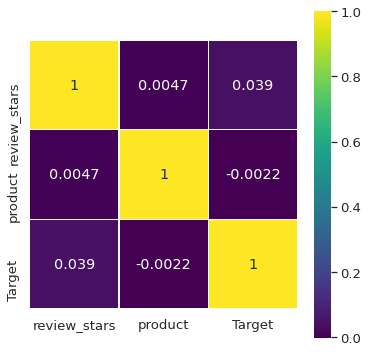

In [17]:
colormap = plt.cm.viridis
plt.figure(figsize=(6,6))
sns.set(font_scale=1.2)
sns.heatmap(data.corr(), 
            linewidths=0.05, 
            square=True, 
            cmap=colormap, 
            annot=True)
#sns.pairplot(data, hue="Target")

# 2) Data pre-processing

For cleaning the text, columns 'review_content' and 'review_title', we proceed as follows:

 * Normalisation du texte
 * Tokenization
 * Suppression des stopwords
 * Stemming & Lemmatization
 * TF-IDF (N-grams => MemoryError)

## 2.1) Normalisation & tokenization

We put the text in lowercase then we separate the terms.

In [18]:
# List of dataframes to handle
data_list = [data['review_content'],
           data['review_title']]

def df_modif(df, modif, ind):
    if ind == 0:
        data['review_content'] = modif
    elif  ind == 1:
        data['review_title'] = modif
             
for index, df in enumerate(data_list):
    # Normalisation
    res = df.apply(lambda r: str(r).lower())     
    # Tokenization
    res = res.apply(lambda r: word_tokenize(r))
    df_modif(df, res, index)

## 2.2) Removing stop words

We remove all stopwords and punctuation.

In [19]:
stop_words = stopwords.words('french')
ponctuation = set(string.punctuation)
stop_words.extend(ponctuation)
stop_words.extend(["a", "''", "``"])
#stop_words

In [20]:
def stopwords_row(row):
    return [word for word in row if word not in stop_words]

for index, df in enumerate(data_list):
    # Removing stopwords
    res = df.apply(stopwords_row)   
    df_modif(df, res, index)

## 2.3) Lemmatization et Stemming

For the analysis of the text, one can use the methods of lemmatization and stemming. The first consists in bringing each word closer to its canonical form, for example the infinitive of a verb, while the second, more drastic, retains only the root of the words.

We can test the two methods to check which one allows a performance gain, because it could be that the stemming induces a loss of information, although more interesting in term of computation time.
Indeed, finally only doing the lemmatization allows a performance gain of 0.5% on the final roc_auc score, so we can do without the stemming step.

In [21]:
#from cltk.lemmatize.french.lemma import LemmaReplacer 
#lemma = LemmaReplacer() => file not found
lemma = FrenchLefffLemmatizer()  # WordNetLemmatizer()
stemmer = FrenchStemmer()

def join_lemmatize(sent):
    return ' '.join(sent)

for index, df in enumerate(data_list):
    # Lemmatization
    res = df.apply(lambda x: [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w, 'v'), 'n'), 'a') for w in x])
    
    # Stemming
    #res = res.apply(lambda x: [stemmer.stem(w) for w in x]) #x.split()
     
    res = res.apply(lambda row: join_lemmatize(row))
    df_modif(df, res, index)

## 2.4) TF-IDF

Once the text has been simplified, we encode the words with a Bag of Words approach.
A vocabulary list is constructed and each word is represented by an integer.
Thus, each sentence is represented by a vector and the Bag of Words matrix makes it possible to apply a Machine Learning algorithm.

To determine what weight to assign to each word, we use the TF-IDF method which allows us to assess the importance of a term relative to the entire corpus.

We perform a TF-IDF transformation using 1500 features because beyond this we get a Memory Error. For the parameters, we choose min_df = 10 to exclude the terms appearing very little, and we choose max_df = 0.7 to keep only the terms appearing in at most 70% of the data to avoid using the too frequent terms which are likely not to appear information (as in the case of stopwords). A test at 95% of terms generated a result of 0.5% worse.
We don't use N-grams, we only consider each me alone, again for Memory Error reasons.

In [22]:
vect = TfidfVectorizer(stop_words=stop_words, 
                       analyzer = 'word',
                       max_features=1200, #1500, 2000 plante
                       lowercase=False,#,
                       max_df = 0.7, # 0.95 => moins bon
                       min_df=10)#, 
                       #ngram_range=(1,2)) # MemoryError

# tfidf sur les colonnes 'review_content' et 'review_title'
tfidf = vect.fit_transform(data['review_content'] + " " + data['review_title'])

df_tfidf = tfidf
df_tfidf.toarray()
feature_names = vect.get_feature_names()
dense = df_tfidf.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)
df_tfidf.head()

,10,100,12,15,16,18,1er,20,2010,25,...,élégant,énorme,épisode,époque,équiper,équivalent,état,étoiler,éviter,être
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128981,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [23]:
# on ajoute les colonnes review_stars et product
df = pd.concat([df_tfidf, data.iloc[:, 2:4]], axis=1)
print(df.shape)

(60000, 1202)


## 2.5) Hashing Vectorizer

To work around memory issues, I tested HashingVectorizer, with a number of features up to 2000.
However, I had several problems: I couldn't get the names of the variables, so I tried InvertableHashingVectorizer, but a \_get\_haser function was not found. In this case, not possible to reconstruct the dataframe, I could not test this track until the end.

In [24]:
"""vect_hash = HashingVectorizer(stop_words='english', 
                        analyzer = 'word', 
                        n_features=2000,
                        lowercase=False)

df_tfidf_hash = vect_hash.fit_transform(data['review_content'] + " " + data['review_title'])
df_tfidf_hash.toarray()

# AttributeError: 'HashingVectorizer' object has no attribute 
# 'get_feature_names'

feature_names = vect_hash.get_feature_names()
# pour récupérer les noms des features:
from eli5.sklearn import InvertableHashingVectorizer
ivec = InvertableHashingVectorizer(df_tfidf_hash) 

# => AttributeError: _get_hasher not found

ivec.fit(df) 
names = ivec.get_feature_names()"""

'vect_hash = HashingVectorizer(stop_words=\'english\', \n                        analyzer = \'word\', \n                        n_features=2000,\n                        lowercase=False)\n\ndf_tfidf_hash = vect_hash.fit_transform(data[\'review_content\'] + " " + data[\'review_title\'])\ndf_tfidf_hash.toarray()\n\n# AttributeError: \'HashingVectorizer\' object has no attribute \n# \'get_feature_names\'\n\nfeature_names = vect_hash.get_feature_names()\n# pour récupérer les noms des features:\nfrom eli5.sklearn import InvertableHashingVectorizer\nivec = InvertableHashingVectorizer(df_tfidf_hash) \n\n# => AttributeError: _get_hasher not found\n\nivec.fit(df) \nnames = ivec.get_feature_names()'

# 3) Dimension reduction

## 3.1) Principal Composant Analysis 

In order to reduce the number of features, a dimension reduction is carried out for the Principal Component Analysis (PCA) method.
The maximum number of components that can be reached is 400, but the result is not very satisfactory since the percentage of explanation of variance accumulated is only about 36%.

I tested a PCA with as a parameter the percentage of cumulative variance explanation (at 60%) to reach, but that makes the core crash. So I stay with n_comp = 400 components fixed.

In [25]:
X = df
#X_test = df_test
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#std_test_scale = preprocessing.StandardScaler().fit(X_test)
#X_test_scaled = std_scale.transform(X_test)


--------------------------------------------------------
Explained variances:  [0.00668584 0.0061114  0.0036193  0.00344199]
Total explained variance: 24.89%
--------------------------------------------------------


n_components_:  200


/home/christelle/anaconda3/envs/linkvalue/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


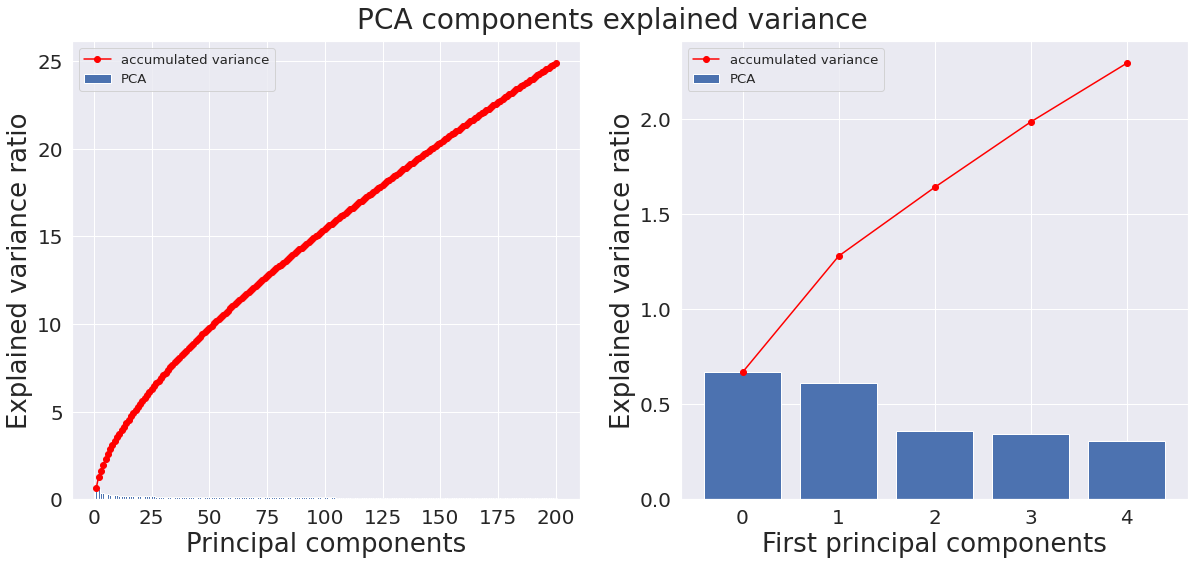

In [26]:
n_comp = 200
# Calcul des composantes principales
pca = PCA(n_components=n_comp)
#pca = PCA(0.6)
pca.fit(X_scaled)

X_valid_pca = pca.transform(X_scaled)  
#X_test_pca = pca.transform(X_test_scaled) 

print("\n--------------------------------------------------------")
explained_variance = pca.explained_variance_ratio_  
print("Explained variances: ", explained_variance[:4])
print("Total explained variance: %0.2f%%" % (100*explained_variance.sum()))
print("--------------------------------------------------------\n\n")

print("n_components_: ", pca.n_components_)

#----------------- FIGURES -----------------
fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle('PCA components explained variance', fontsize=28)
scree = pca.explained_variance_ratio_*100
ax[0].bar(np.arange(len(scree))+1, scree, label="PCA")
ax[0].plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o', label="accumulated variance")
ax[0].set_xlabel("Principal components", fontsize=26)
ax[0].set_ylabel("Explained variance ratio", fontsize=26)
plt.setp(ax[0].get_xticklabels(), fontsize=20)
plt.setp(ax[0].get_yticklabels(), fontsize=20)
ax[0].legend(loc="upper left")
plt.subplots_adjust(hspace = 0.3, top=0.92) 
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
ax[1].bar(np.arange(5), scree[:5], label="PCA")
ax[1].plot(np.arange(5), scree.cumsum()[:5],c="red",marker='o', label="accumulated variance")
ax[1].set_xlabel("First principal components", fontsize=26)
ax[1].set_xticks(np.arange(1,5),('PC1','PC2','PC3','PC4'))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax[1].set_ylabel("Explained variance ratio", fontsize=26)
ax[1].legend(loc="upper left")
plt.show()

The graph shows that the 1st component contains 0.5% of the information, and the 2nd also. In total, we obtain only 36% of the total variance by cumulating the 400 components, which is not satisfactory.

The variance curve continues to grow, so more components would be needed to obtain a reliable result for model training and prediction.

Below we display the projections of the main components.

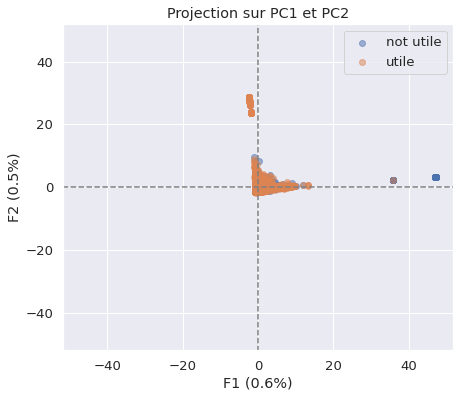

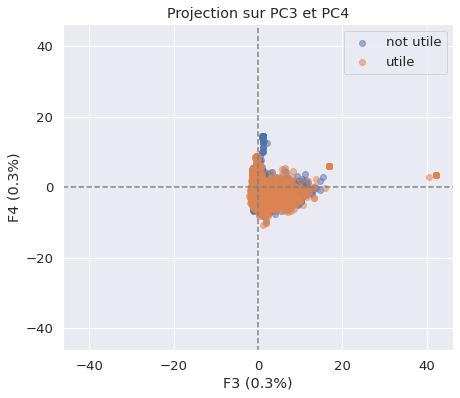

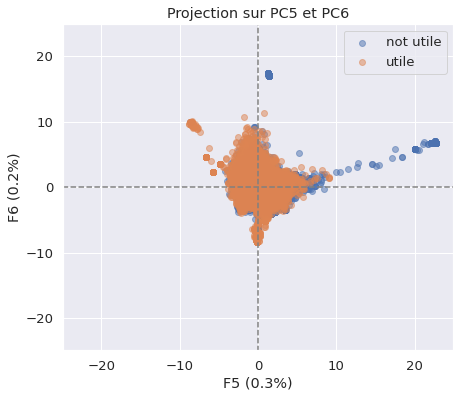

In [28]:
def display_factorial_planes(X_projected, data, pca, axis_ranks, alpha=1):
    for d1,d2 in axis_ranks:
        fig = plt.figure(figsize=(7,6))
        targets = [0, 1]
        targets_name = ['not utile', 'utile']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = data['Target'] == target
            plt.scatter(X_projected[indicesToKeep, d1], 
                        X_projected[indicesToKeep, d2], 
                        alpha=alpha, 
                        label=targets_name[target])
        plt.legend()

        boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
        plt.xlim([-boundary,boundary])
        plt.ylim([-boundary,boundary])
        plt.plot([-100, 100], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-100, 100], color='grey', ls='--')
        plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
        plt.title("Projection sur PC{} et PC{}".format(d1+1, d2+1))
        plt.show(block=False)


display_factorial_planes(X_valid_pca, data, pca, 
                         [(0,1),(2,3),(4,5)],
                         alpha = 0.5)

We observee that the 2 classes are not well separated, the variables are therefore well correlated. The data is well clustered, apart from a few outliers.

Therefore, the PCA, although making it possible to reduce the dimension, will imply a loss of information due to the low percentage of cumulative variance explained.
However, in this context where memory problems remain, we choose to keep the main components to continue our calculations.

## 3.2) Incremental PCA

An improvement consists in considering an incremental PCA.
Indeed, by applying the Incremental PCA method, we increase the number of components, and also the cumulative explained variance rate. We choose 1000 components, which is similar to the number of features of the basic dataframe (1500), but allows more calculations to be made in the following.

A test with 1200 components did not bring any further improvement to the final result.

In [28]:
m, n = df.shape
n_batches = 10
n_components = 1000

ipca = IncrementalPCA(
    copy=False,
    n_components=n_components,
    batch_size=(m // n_batches)
)
X_valid_ipca = ipca.fit_transform(X_scaled)  
#X_test_ipca = ipca.transform(X_test_scaled) 

After calculations, the incremental PCA makes it possible to obtain 70% of the cumulative variance explained and to gain 0.6% on the final ROC AUC score compared to the usual PCA, so we choose the incremental PCA.

### Other tracks

Other methods have been tested to try to improve performance:
* Truncated SVD
* StandardScaling de numpy 
* .partial_fit

=> MemoryError

In [30]:
"""n_comp = 250
svd = decomposition.TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd.fit(df)
print(svd.explained_variance_ratio_.sum())
df = svd.fit_transform(df) 
"""

"""X = data
std = X.std(0) 
mean = X.mean(0)
scaler = StandardScaler(copy=False) 
scaler.std_ = std
scaler.mean_ = mean
XX = scaler.transform(X)
"""

'X = data\nstd = X.std(0) \nmean = X.mean(0)\nscaler = StandardScaler(copy=False) \nscaler.std_ = std\nscaler.mean_ = mean\nXX = scaler.transform(X)\n'

## 3.3) t-SNE

We carry out a dimension reduction via the t-SNE method in order to check if we can improve the results.

This method is much more expensive in term of computation time and did not make it possible to improve the precision of the model, one will thus preserve the incremental PCA.

In [50]:
tsne_ = 1
if tsne_:
    tsne = TSNE()
    X = X_scaled
    X_embedded = tsne.fit_transform(X)
    sns.scatterplot(X_embedded[:,0], 
                X_embedded[:,1], 
                hue=data['Target'], 
                legend='full')

![alt text](tsne.png "t-SNE")

# 4) Classification

## 4.1) Train/test splitting

To train a model, first perform a train / splitting test on the dataset from the train.csv file, used to validate the model.

In [29]:
X = X_valid_ipca
#X = X_embedded # moins bons résultats avec la t-SNE
#X = df # MemoryError
y = data['Target']
X_train, Xv_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    train_size=0.7,
                                                   random_state=2) 

In [30]:
# normalisation des données
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
Xv_test_std = std_scale.transform(Xv_test)

## 4.2) Cross-validation on models

We perform a cross validation with 4 models to evaluate which model to choose for a baseline.
We choose the Logistic Regression, Decision Tree, Random Forest and LightGBM models for their speed of execution compared to the K-means algorithm and SVM.
Cross validation is performed on 5 folds.

For the metrics we consider the area under ROC curve (ROC AUC) and the accuracy, which are metrics well suited to binary classification problems on balanced datasets.

The display of the scores on the train and test games, as well as the CPU times make it possible to determine a good compromise between precision and cost without doing too much over-fitting of the data.

In [34]:
models = []
models.append(('Logistic Regression    ', LogisticRegression()))
#models.append(('K-Nearest Neighbors    ', KNeighborsClassifier())) 
models.append(('Decision Tree          ', DecisionTreeClassifier()))
models.append(('Random Forest          ', RandomForestClassifier()))
#models.append(('Support Vector Machine ', SVC()))
models.append(('LightGBM               ', LGBMClassifier()))

print("*****************************************")
print("        Cross-validation results")
print("*****************************************\n")

scores = ['roc_auc', 'accuracy'] 
cross_val = 1
if cross_val:
    for score in scores:
        print(score)
        for name, model in models:
            start = time.time()
            cv_results = cross_validate(model, X_train_std, y_train, 
                                        cv=5, 
                                        return_train_score=True, 
                                        scoring = score)
            stop = time.time()
            print("%s = %0.5f (train) / %0.5f (test) (CPU: %0.3f)" % 
                  (name, cv_results['train_score'].mean(), cv_results['test_score'].mean(), stop-start))
        print("")

*****************************************
        Cross-validation results
*****************************************

roc_auc
Logistic Regression     = 0.72320 (train) / 0.67954 (test) (CPU: 6.486)
Decision Tree           = 1.00000 (train) / 0.57787 (test) (CPU: 452.864)
Random Forest           = 1.00000 (train) / 0.69165 (test) (CPU: 803.498)
LightGBM                = 0.90496 (train) / 0.70218 (test) (CPU: 136.906)

accuracy
Logistic Regression     = 0.66412 (train) / 0.63305 (test) (CPU: 5.292)
Decision Tree           = 1.00000 (train) / 0.58224 (test) (CPU: 441.704)
Random Forest           = 1.00000 (train) / 0.64117 (test) (CPU: 798.281)
LightGBM                = 0.81399 (train) / 0.64883 (test) (CPU: 134.487)



According to the results, a good choice of model would be Logistic Regression, which with equivalent precision, allows to reduce over-fitting.
The best scores are obtained with the LightGBM but it does more over-fitting than the Logistic Regression.
In terms of computing time, the Logistic Regression is faster, we choose this model for a baseline.

## 4.3) Logistic regression

### 4.3.1) Baseline model

A baseline model provides a benchmark for performance, which we will then try to improve. For the basic model, we choose Logistic Regression, which is a simple model widely used for binary classification problems.

In [31]:
clf = LogisticRegression()
# Apply logistic regression to train data
clf.fit(X_train_std, y_train)
# Predicting with trained model
y_predicted = clf.predict(Xv_test_std)

### Performances

The results show that class 1 of useful comments is better classified by the algorithm than class 0. But this may be due to the fact that the dataset contains 10% more elements labeled 'useful'.

In [32]:
def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.638, recall = 0.641, f1 = 0.636


In [37]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      8013
           1       0.66      0.74      0.69      9987

    accuracy                           0.64     18000
   macro avg       0.64      0.63      0.63     18000
weighted avg       0.64      0.64      0.64     18000



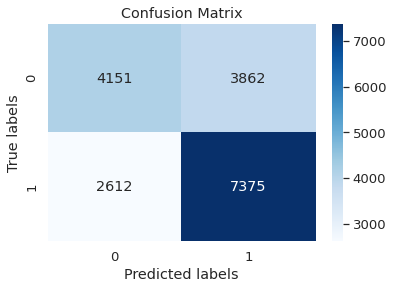

In [38]:
cm = confusion_matrix(y_test, y_predicted)
ax = plt.subplot()
sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

The confusion matrix allows us to observe that the algorithm generates a lot of false positives, which shows that the algorithm has trouble classifying comments that are not useful.
The number of true positives being the most important, the algorithm manages to classify the really useful comments well.

### Courbe AUC ROC

roc_auc_score: 0.689


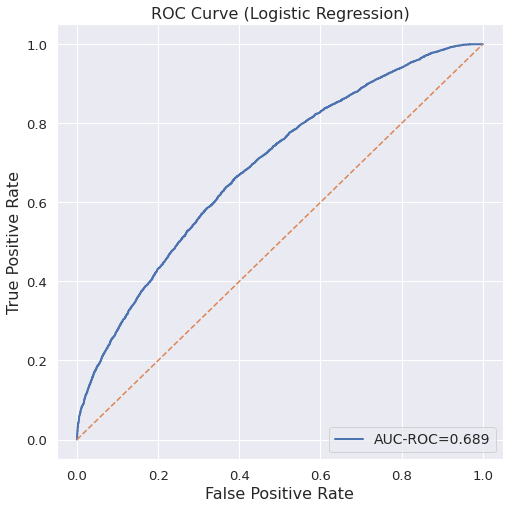

In [39]:
y_pred_proba = clf.predict_proba(Xv_test_std)[:,1]
fpr, tpr, thr_roc = roc_curve(y_test, y_pred_proba)
auc_roc = auc(fpr,tpr)

ras = roc_auc_score(y_test, y_pred_proba)
print("roc_auc_score: %.3f" % ras)
    
#----------------- FIGURE AUC -----------------
fig, ax = plt.subplots(1, figsize=(8,8))
ax.plot(fpr, tpr, '-', lw=2, label='AUC-ROC=%.3f' % auc_roc)
ax.plot([0, 1], [0, 1],linestyle='--')
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('ROC Curve (Logistic Regression)',fontsize=16)
ax.legend(loc="lower right", fontsize=14)

The AUC-ROC score for the area under the ROC curve is 0.689, which is not exceptional. However, we can say that the algorithm does a pretty good job of distinguishing between classes.

### 4.3.2) Variation of the adjustment parameter

The regularization parameter C is varied in order to try to improve the performance. We get an improvement of $ 1 \% $ for the smallest coefficient $ C = 10 ^ {- 3} $ and $ C = 10 ^ {- 4} $, with the risk of under-fitter.
We can therefore consider the default model without loss of performance.

In [40]:
C_param_range = [0.0001, 0.001,0.1,1] # defaut 0.1

for i in C_param_range:
    print("\nC = ", i)
    clf = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    clf.fit(X_train_std, y_train)
    
    y_predicted = clf.predict(Xv_test_std)
    cm = confusion_matrix(y_test, y_predicted)
    print(cm)
    
    y_pred_proba = clf.predict_proba(Xv_test_std)[:,1]
    fpr, tpr, thr_roc = roc_curve(y_test, y_pred_proba)
    auc_roc = auc(fpr,tpr)

    ras = roc_auc_score(y_test, y_pred_proba)
    print("roc_auc_score: %.3f" % ras)


C =  0.0001
[[3065 4948]
 [1600 8387]]
roc_auc_score: 0.689

C =  0.001
[[4027 3986]
 [2475 7512]]
roc_auc_score: 0.689

C =  0.1
[[4152 3861]
 [2611 7376]]
roc_auc_score: 0.689

C =  1
[[4151 3862]
 [2612 7375]]
roc_auc_score: 0.689


# 5) Grid search on Random Forest

A way to improve performance may be to use a Grid-search algorithm.
We apply this algorithm to the Random Forest classifier, which allows us to test other hyper-parameters of the default classifier.
This test is inconclusive because we always get over-fitting since the score on the training game is close to 1 while the score on the test game is around 0.7.

In [41]:
X = X_valid_pca 
#X = X_valid_ipca # OSError Cannot allocate memory
y = data['Target']
X_train_gs, Xv_test_gs, y_train_gs, y_test_gs = train_test_split(X, y, 
                                                    stratify=y, 
                                                    train_size=0.8,
                                                   random_state=2) 
# normalisation des données
std_scale = preprocessing.StandardScaler().fit(X_train_gs)
X_train_std_gs = std_scale.transform(X_train_gs)
Xv_test_std_gs = std_scale.transform(Xv_test_gs)

In [42]:
# 1200 IPCA => TerminatedWorkerError 
# StratifiedShuffleSplit => plante
rf = RandomForestClassifier()
nbsplit = 3
#cv = StratifiedShuffleSplit(n_splits=nbsplit, test_size=0.3, random_state=20)
cv = 3 # cv = 5 => TerminatedWorkerError
params = {'n_estimators': [200], # 400, 1000 => plante
            'max_depth': [40], # 10
            'min_samples_split': [5], # 2
            'min_samples_leaf': [5], # 10
            'random_state': [112]
            }   
print("Training... )\n")    
clf_gs = GridSearchCV(rf, 
                    params, 
                    scoring = 'roc_auc',
                    cv = cv,
                    return_train_score=True,
                    n_jobs=-1)
gs = 1
if gs:
    clf_gs.fit(X_train_std_gs, y_train_gs)

    best_params = clf_gs.best_estimator_
    print("Best Parameters: ", best_params)
    print("Best Score: %.2f%%" % ((clf_gs.best_score_)*100))

    print('Mean train score: {}'.format(clf_gs.cv_results_['mean_train_score']))
    print('Mean test score: {}'.format(clf_gs.cv_results_['mean_test_score']))

Training... )

Best Parameters:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=112,
                       verbose=0, warm_start=False)
Best Score: 71.39%
Mean train score: [0.99876756]
Mean test score: [0.7139272]


# 6) LightGBM

To improve performance, we can consider a LightGBM algorithm which is more efficient than the previous ones. We apply the LightGBM model with a few more estimators than in the default model (200 instead of 100) and we gain 3.4% on the ROC-AUC score, which is the best improvement made so far. However, it should be remembered that cross-validation has shown that the over-fit algorithm, but less than the Random Forest.

In [43]:
model_params = {'random_state': 2,    
                'learning_rate': 0.1,                
                'n_estimators': 200}

gbm = LGBMClassifier(**model_params)
gbm.fit(X_train_std, y_train)

y_pred_gbm = gbm.predict(Xv_test_std)

In [44]:
print(classification_report(y_test,y_pred_gbm))

              precision    recall  f1-score   support

           0       0.64      0.50      0.56      8013
           1       0.66      0.77      0.71      9987

    accuracy                           0.65     18000
   macro avg       0.65      0.64      0.63     18000
weighted avg       0.65      0.65      0.64     18000



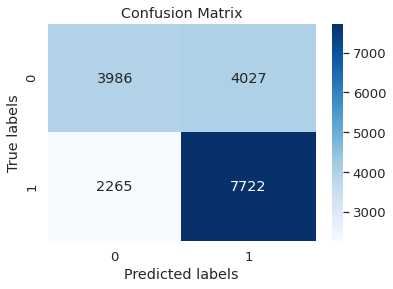

In [45]:
cm = confusion_matrix(y_test, y_pred_gbm)
ax = plt.subplot()
sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

On the confusion matrix, we observe that we always have a high rate of false positives.

roc_auc_score: 0.710


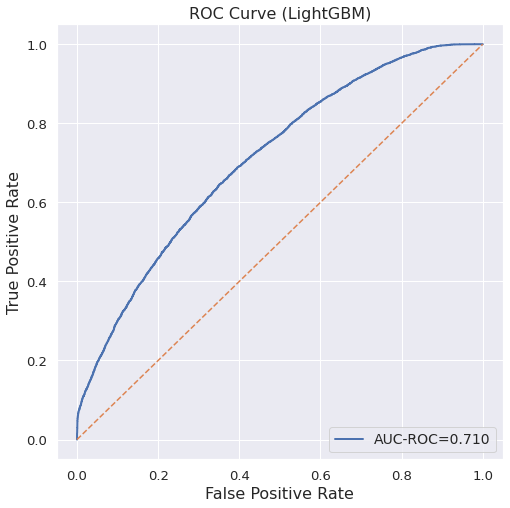

In [46]:
y_pred_proba_gbm = gbm.predict_proba(Xv_test_std)[:,1]
fpr, tpr, thr_roc = roc_curve(y_test, y_pred_proba_gbm)
auc_roc_gbm = auc(fpr,tpr)

ras = roc_auc_score(y_test, y_pred_proba_gbm)
print("roc_auc_score: %.3f" % ras)
    
#----------------- FIGURE AUC -----------------
fig, ax = plt.subplots(1, figsize=(8,8))
ax.plot(fpr, tpr, '-', lw=2, label='AUC-ROC=%.3f' % auc_roc_gbm)
ax.plot([0, 1], [0, 1],linestyle='--')
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('ROC Curve (LightGBM)',fontsize=16)
ax.legend(loc="lower right", fontsize=14)

Here, we obtain a ROC-AUC result of 0.710, which improves the previous scores. We therefore keep this model to make the prediction on the test set.

# 7) Conclusion

This is a binary classification problem on categorical (text) and numeric variables.
The dataset, although well balanced at the level of classes 0 and 1 (non-useful and useful comments), was difficult to process due to systematic memory problems.

The One-Hot-encoding of the variable 'product' generated far too many variables to be able to make a more precise study. We might have been able to gain performance with better encoding of this variable.

For the TF-IDF transformation, again memory problems prevented me from varying the parameters a little more, like taking more features, or testing with bi-grams, which might have improved the result.

The result for the area under the ROC curve is around 0.68 for the tests carried out with the Logistic Regression and Random Forest models. Despite several attempts, I failed to improve this score. Finally, the LightGBM algorithm made it possible to gain 3.4% improvement on the final score without tuning the hyper-parameters, but has the disadvantage of doing more over-fitting.

For the choice of the final model, I used LightGBM despite the fact that the algorithm was over-fitting. I could have chosen Logistic Regression, which does not over-fit, but performs less well for ROC-AUC, with a shorter calculation time.
